# [2] t-SNE visualization of Amazon Fine Food Reviews with polarity based color-coding

## [ 2.1 ]Objective  
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


## [ 2.2 ]Data Overview 
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>
568,454 food reviews Amazon users left up to October 2012 <br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - Unique identifier for the product
3. UserId - Unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - Rating between 1 and 5
8. Time - Timestamp for the review
9. Summary - Brief summary of the review
10. Text - Text of the review

## [ 2.3 ]Loading The Data
The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [72]:
%matplotlib inline

import sqlite3
import nltk
import string
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# using the SQLite Table to read data.
con = sqlite3.connect('./Dataset/database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [32]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## [ 2.4 ]Exploratory Data Analysis : 
### [ 2.4.1 ]Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [33]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


<b>Observation(s):-</b>As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [34]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [35]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [36]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [37]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [38]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [39]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [40]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 138706 to 302474
Data columns (total 10 columns):
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null object
Time                      364171 non-null int64
Summary                   364171 non-null object
Text                      364171 non-null object
dtypes: int64(4), object(6)
memory usage: 30.6+ MB


### [ 2.4.2 ]Text Preprocessing: Stemming, stop-word removal and Lemmatization.
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews


In [41]:
"""Sampling 2k datapoints for preprocessing"""
final=final[0:2000] 

In [42]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [43]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'they', 'm', 'under', 'both', "doesn't", 't', 'until', 'but', 'against', 'doing', 'further', 'to', 'just', 'ain', 'having', 'you', 'been', 'theirs', "hasn't", 'did', "won't", 'how', 'when', "couldn't", 'where', 'shan', 'yourselves', 'again', 'will', 'those', 'here', 'very', 'was', 'themselves', "shouldn't", 'between', 'y', 'has', 'nor', 'yourself', 'no', 'in', 'hasn', "weren't", 'its', 'your', 'on', 'who', 'why', 'itself', 'i', 'her', 'few', "haven't", 'isn', 'them', 'shouldn', 'up', 'there', "you're", 'or', 'him', "aren't", 'me', 'mightn', "mustn't", 'their', 'what', 'with', 'by', 'his', "should've", 'because', 'wasn', 're', 'wouldn', "wasn't", 'most', 'about', 'which', 'it', 'same', 'while', 'don', 'be', 'a', 'hers', 'my', 's', 'then', 'were', 'didn', 'ours', 'if', 'any', 'can', 'mustn', 'into', 'won', 'above', 'more', 'through', "she's", 'the', 'from', 'other', 'own', 'are', 'she', 'at', 'herself', 'each', 'do', 'as', 'we', 'ma', 'aren', 'haven', 've', 'than', 'hadn', 'once', 'were

In [44]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [45]:
final['CleanedText']=final_string

In [46]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

##  [ 2.5 ]Bag Of Words

In [47]:
%%time

count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['Text'].values)
type(final_counts)

CPU times: user 201 ms, sys: 3.62 ms, total: 204 ms
Wall time: 577 ms


In [48]:
final_counts.get_shape()

(2000, 10800)

In [59]:
label=final['Score']

"\ntarget=final['Score']\nfeatures=final_counts[0:1000,:]\ntarget=target[0:1000]\nfeatures=features.toarray()\nimport pandas as pd\nfeatures=pd.DataFrame(features)\n"

###  [ 2.5.1 ] t-SNE on Bag Of Words

In [50]:
%%time
'''STANDARDIZATION'''

from sklearn.preprocessing import StandardScaler
standardized_data=StandardScaler(with_mean=False).fit_transform(final_counts)
print(standardized_data.shape)

(2000, 10800)
CPU times: user 16.6 ms, sys: 0 ns, total: 16.6 ms
Wall time: 214 ms


/home/noobwithskills/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [51]:
%%time
'''SINCE *final_counts* is sparse matrix TruncatedSVD is best suitable.'''
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=50, random_state=0).fit_transform(standardized_data)

CPU times: user 1.09 s, sys: 82.6 ms, total: 1.17 s
Wall time: 2.15 s


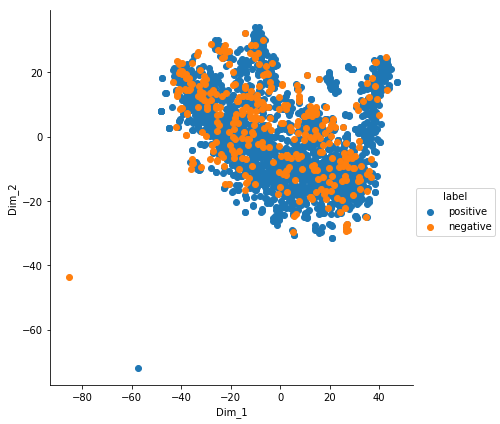

CPU times: user 45.3 s, sys: 2.33 s, total: 47.6 s
Wall time: 47.6 s


In [60]:
%%time
"""
Configuring the parameteres : Default Settings
 the number of components = 2
 perplexity = 30
 learning rate = 200
 Maximum number of iterations for the optimization = 1000
"""
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(tsvd)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T,l)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

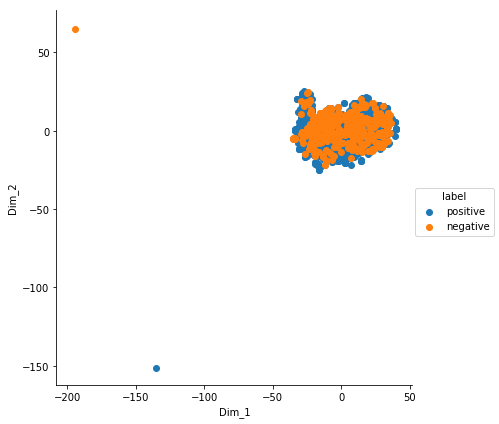

CPU times: user 4min 35s, sys: 10.1 s, total: 4min 46s
Wall time: 4min 46s


In [61]:
%%time
''' TSNE with Perplexity=50
    no of iteration = 5000'''
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=5000)

tsne_data = model.fit_transform(tsvd)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

<b>Observations:-</b>

1) As We change our perplexity and iteration we are getting different plot

2) We are not able to separate positive and negative review 

## [ 2.6 ] TF-IDF

In [62]:
%%time
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final['Text'].values)
final_tf_idf.shape

CPU times: user 213 ms, sys: 3.61 ms, total: 217 ms
Wall time: 305 ms


In [63]:
type(final_tf_idf)

scipy.sparse.csr.csr_matrix

In [64]:
%%time
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(final_tf_idf)
print(standardized_data.shape)

(2000, 10800)
CPU times: user 6.15 ms, sys: 117 µs, total: 6.27 ms
Wall time: 4.96 ms


In [67]:
%%time
"""
Since final_tf_idf is sparse matrix we need to use TruncatedSVD
"""
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=1000, random_state=42).fit_transform(standardized_data)

CPU times: user 18.5 s, sys: 1.36 s, total: 19.9 s
Wall time: 20.5 s


### [ 2.6.1 ] t-SNE on TF-IDF

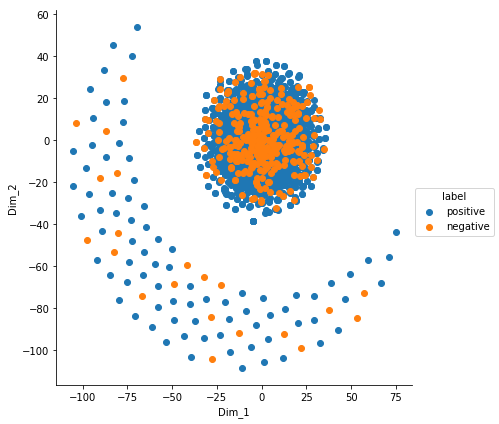

CPU times: user 1min 3s, sys: 2.29 s, total: 1min 5s
Wall time: 1min 6s


In [68]:
%%time
"""
Configuring the parameteres : Default Settings
 the number of components = 2
 perplexity = 30
 learning rate = 200
 Maximum number of iterations for the optimization = 1000
"""
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(tsvd)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

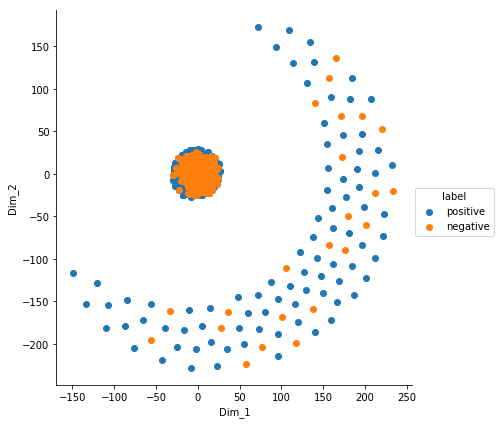

CPU times: user 6min 2s, sys: 11.8 s, total: 6min 14s
Wall time: 6min 14s


In [70]:
%%time
"""
Configuring the parameteres : Default Settings
 the number of components = 2
 perplexity = 50
 learning rate = 200
 Maximum number of iterations for the optimization = 5000
"""
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=5000)

tsne_data = model.fit_transform(tsvd)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

<b>Observations:-</b>

    1) As We change our perplexity and iteration we are getting different plot
    
    2) We are not able to separate positive and negative review 

## [ 2.7 ] Word2Vec

In [74]:
%%time
"""
Training your own Word2Vec model using your own text corpus
"""
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

CPU times: user 1.13 s, sys: 181 ms, total: 1.31 s
Wall time: 5.07 s


In [75]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [76]:
w2v_model.wv.most_similar('tasty')

/home/noobwithskills/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('natural', 0.9975300431251526),
 ('coloring', 0.9975037574768066),
 ('perfect', 0.9974226951599121),
 ('low', 0.9973007440567017),
 ('sense', 0.9972923994064331),
 ('especially', 0.9972808361053467),
 ('soft', 0.997268795967102),
 ('making', 0.9972680807113647),
 ('powerful', 0.997239351272583),
 ('plus', 0.9971760511398315)]

## [ 2.8 ] Avg Word2Vec

In [77]:
""" 
average Word2Vec
compute average word2vec for each review.
"""
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

2000
50


In [78]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(sent_vectors)
print(standardized_data.shape)

(2000, 50)


### [ 2.8.1 ] t-SNE On Avg WORD2VEC

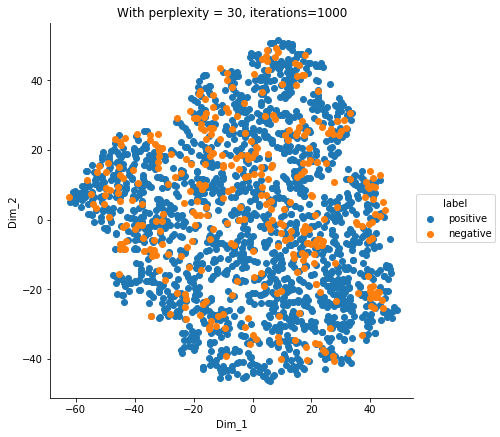

CPU times: user 40.1 s, sys: 2.5 s, total: 42.6 s
Wall time: 44.2 s


In [79]:
%%time
'''
TSNE With Default Settings
configuring the parameteres
    the number of components = 2
    Perplexity = 30
    Learning rate = 200
    Maximum number of iterations for the optimization = 1000
'''
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0)


tsne_data = model.fit_transform(standardized_data)

tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30, iterations=1000')
plt.show()

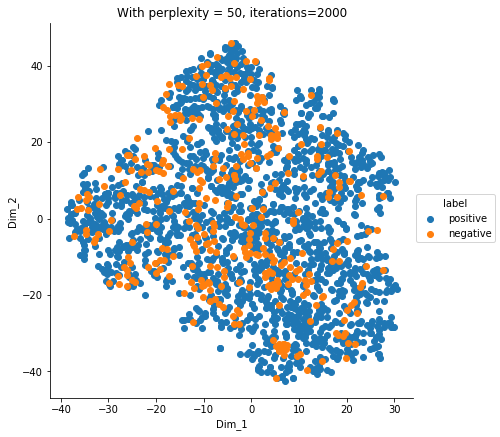

CPU times: user 1min 47s, sys: 5.02 s, total: 1min 52s
Wall time: 1min 52s


In [81]:
%%time
'''TSNE with Perplexity = 50, n_iter=2000'''
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=2000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(standardized_data)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50, iterations=2000')
plt.show()

<b>Observation:- </b>

    1) As We change our perplexity and iteration we are getting different plot

    2) We are not able to separate positive and negative review 

### [ 2.9 ]TFIDF-Word2Vec

In [82]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final['Text'].values)
final_tf_idf.shape

(2000, 10800)

In [97]:
final_tf_idf

<2000x10800 sparse matrix of type '<class 'numpy.float64'>'
	with 131729 stored elements in Compressed Sparse Row format>

In [91]:
%%time
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
            
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

CPU times: user 28.4 s, sys: 8.58 ms, total: 28.4 s
Wall time: 28.3 s


In [95]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(tfidf_sent_vectors)
print(standardized_data.shape)

(2000, 50)


### [ 2.9.1 ]t-SNE on Avg WORD2VEC

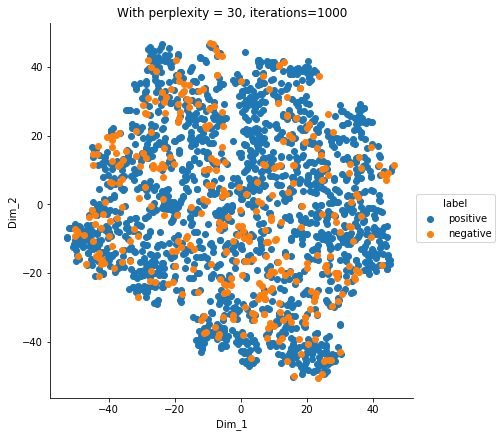

CPU times: user 38.7 s, sys: 2.43 s, total: 41.1 s
Wall time: 41.1 s


In [96]:
%%time
"""TSNE With Default Settings:
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000
"""
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0)


tsne_data = model.fit_transform(standardized_data)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 30, iterations=1000')
plt.show()

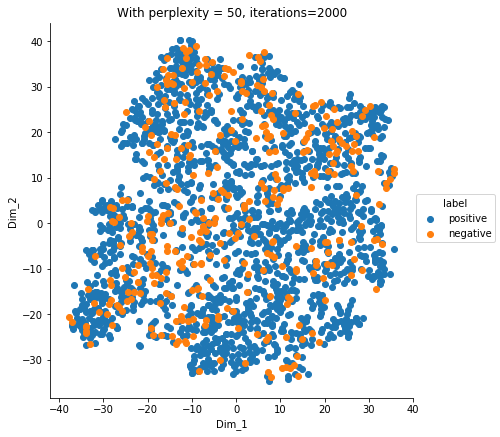

CPU times: user 1min 41s, sys: 5.09 s, total: 1min 46s
Wall time: 1min 46s


In [89]:
%%time
"""
TSNE With 
Perplexity = 50
No of iterations = 2000
"""
from sklearn.manifold import TSNE
import seaborn as sn
model = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=2000)

tsne_data = model.fit_transform(standardized_data)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50, iterations=2000')
plt.show()

<b>Observation:-</b>

    1) As We change our perplexity and iteration we are getting different plot

    2) We are not able to separate positive and negative review 